<img src="https://www.uv.es/recursos/fatwirepub/ccurl/958/517/Cap_ETSE_UV_es.png" align="right" style="float" width="500">

<font color="#000000"><h1 align="left">Análisis semántico latente</h1></font>

<font color="#CA3532"><h2 align="left">Master en Ciencia de Datos</h2></font>

<font color="#6E6E6E"><h2 align="left">Análisis de señales </h2></font>

<font color="#6E6E6E"><h3 align="left">12-11-21 </h3></font> 
<br/>
<h3 align="left">Autores:</h3>
<p>Carlos Martínez Sotorres</p>
<p>José Manuel Sánchez Aquilué</p>
<p>Noah Villaescusa Topper</p>


In [12]:
# import libraries
import urllib.request

from pandas import DataFrame
import itertools

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

# Extracción de datos

Es necesario contar con un conjunto de datos con un volumen importante de documentos para entrenar a nuestro modelo. Nosotros hemos decidido utilizar estos artículos que pone a nuestra disposición datacamp. Importaremos los datos desde la url, de manera que en cada ejecución trabajaremos con la última versión del fichero.

In [13]:
# load data
url = "https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Latent+Semantic+Analysis+in+Python/articles+4.txt"
file = urllib.request.urlopen(url)

Una vez importado, procedemos a realizar una lectura linea a linea (ya que los artículos se disponen por lineas de texto). Los documentos, representados como cadenas de texto, serán almacenados en una lista. Se podría utilizar alguna otra estructura de datos, pero para este ejemplo es buena idea emplear una lista.

Por último, aclarar que la codificación original del fichero no es válida para trabajar directamente, hace falta hacer una decodificación a `utf-8`.

In [14]:
documents = []

for line in file:
  decoded_line = line.decode("utf-8")
  text = decoded_line.strip()
  documents.append(text)

# Exploración de datos

Una vez que tengamos los documentos almacenados en una lista, procedemos a examinarlos. El primer paso consistirá en comprobar con cuántos elementos contamos.

In [15]:
print("Number of documents:", len(documents))

Number of documents: 4551


Por otro lado, nos interesa conocer la dimensión de cada texto.

In [16]:
numchar_by_doc = DataFrame(map(len, documents))

numchar_by_doc.describe()

,0
count,4551.000000
mean,5477.652604
std,6357.940083
min,410.000000
25%,2726.000000
50%,4321.000000
75%,5962.500000
max,96917.000000


Se aprecia que por lo general son artículos de entre 2500 y 6000 caracteres. No obstante hay bastantes documentos cuya extensión supera con creces la media.

In [17]:
print("Número de artículos muy largos:", (numchar_by_doc > 20000).sum()[0])
print("Número de artículos largos:", (numchar_by_doc > 6000).sum()[0])
print("Número de artículos cortos:", (numchar_by_doc < 2500).sum()[0])


Número de artículos muy largos: 114
Número de artículos largos: 1119
Número de artículos cortos: 963


A continuación mostramos un par de gráficos con la distribución del tamaño de los artículos.

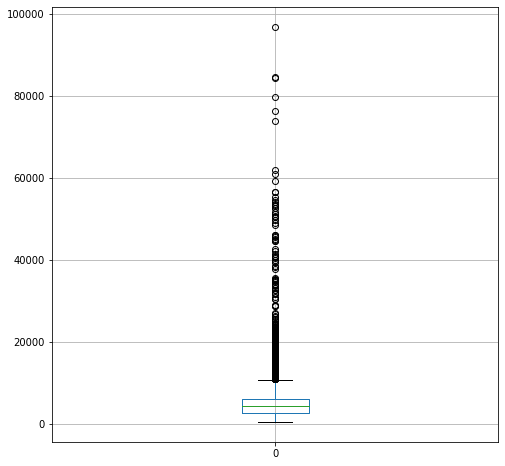

In [18]:
numchar_by_doc.boxplot(figsize=(8,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcf7690bd10>]],
      dtype=object)

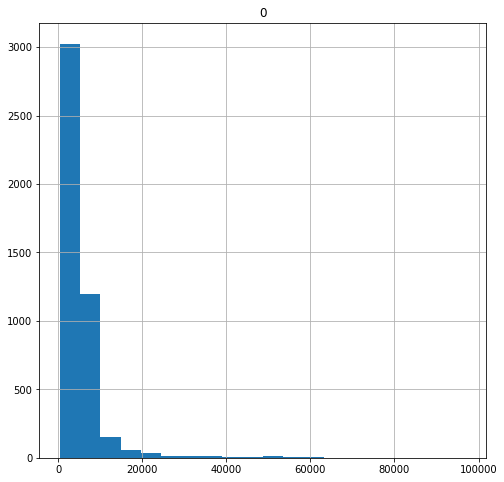

In [19]:
numchar_by_doc.hist(figsize=(8,8), bins = 20)

Más adelante después de eliminar las stopwords y hacer stemming veremos como en base a esos artículos hemos construido un diccionario de 49792 palabras. 

# Preprocesado

Antes de construir la bolsa de palabras vamos a "limpiar" los documentos. Podemos dividir el preprocesado en estas cuatro fases:
*   Convertir a minúsculas
*   Dividir por espacios en blanco (tokenizar)
*   Eliminar "stopwords"
*   Stemming 



Aplicado una expresión regular se construye un "tokenizer", el cual aplicado al documento dividirá por los espacios en blanco el mismo y obtendrá los tokens.

In [20]:
tokenizer = RegexpTokenizer(r'\w+')

A continuación, mediante la librería nltk se obtienen las "stopwords" del lenguaje especificado, en este caso corresponde el inglés. Esta lista es muy extensa por lo que generarla manualmente sería costoso, además existiría una alta probabilidad de estar incompleta.

In [21]:
nltk.download('stopwords')
en_stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


El stemming se realiza mediante el algoritmo de Porter, el algoritmo más común para stemming. Este permite extraer los sufijos y prefijos de una palabra para obtener la raíz común.

In [22]:
p_stemmer = PorterStemmer()

Por último solo queda aplicar los pasos mencionados sobre los textos. El primer paso es convertir a minúsculas el documento, tras ello se obtienen los tokens, un array de palabras completas sobre el cual se trabaja para eliminar las "stopwords", y por último se aplica el stemmer para realizar el stemming y conseguir una colección de documentos corregidos y normalizados.

In [23]:
clean_docs = []
for doc in documents:
  lower_case = doc.lower()
  tokens = tokenizer.tokenize(lower_case)

  stopped_tokens = [i for i in tokens if not i in en_stop]
  
  stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
  
  clean_docs.append(stemmed_tokens)

# Implementación del modelo

El diccionario lo vamos a generar a través de la clase homónima de la biblioteca corpora.

In [24]:
dictionary = corpora.Dictionary(clean_docs)

In [25]:
len(dictionary)

49792

Esa clase tiene un atributo que dado un documento devuelve su representación en bolsa de palabras. De manera que al aplicar esa función en sobre todos los articulos obtendremos la matriz término-documento.

In [26]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_docs]

A partir de la matriz podemos elaborar nuestro modelo indicando el número de temas. 

In [27]:
N = 7 # number of topics

In [28]:
# construct lsamodel
lsamodel = LsiModel(doc_term_matrix, num_topics = N, id2word = dictionary)

Una vez construido el modelo, vamos a ver las palabras más relevantes de cada tema e intentaremos averiguar cómo ha clasificado los artículos.

In [29]:
N_WORDS = 12
print(lsamodel.print_topics(num_topics = N, num_words=  N_WORDS))

[(0, '0.361*"trump" + 0.272*"say" + 0.233*"said" + 0.166*"would" + 0.160*"clinton" + 0.140*"peopl" + 0.136*"one" + 0.126*"campaign" + 0.123*"year" + 0.110*"time" + 0.110*"like" + 0.108*"go"'), (1, '0.389*"citi" + 0.370*"v" + 0.356*"h" + 0.355*"2016" + 0.354*"2017" + 0.164*"unit" + 0.159*"west" + 0.157*"manchest" + 0.116*"apr" + 0.112*"dec" + -0.108*"trump" + 0.085*"leicest"'), (2, '0.612*"trump" + 0.264*"clinton" + -0.261*"eu" + -0.148*"say" + -0.137*"would" + 0.135*"donald" + -0.134*"leav" + -0.134*"uk" + 0.119*"republican" + -0.110*"cameron" + -0.105*"brexit" + -0.104*"britain"'), (3, '-0.400*"min" + 0.261*"eu" + -0.183*"goal" + -0.152*"ball" + -0.132*"play" + 0.128*"said" + 0.128*"say" + -0.126*"leagu" + 0.122*"leav" + -0.122*"game" + -0.117*"1" + 0.116*"vote"'), (4, '0.404*"bank" + -0.305*"eu" + -0.290*"min" + 0.189*"year" + -0.164*"leav" + -0.153*"cameron" + 0.143*"market" + 0.140*"rate" + -0.139*"vote" + -0.133*"say" + -0.124*"campaign" + 0.108*"financi"'), (5, '0.310*"bank" + -0


*   Tema 1: Elecciones presidenciales de EEUU de 2016 (trump, say, said, would, clinton, people, one, campaign, year, time...)
*   Tema 2: Premier League (citi, v, h, 2016, 2017, unit, manchest, apr ,dec...)
*   Tema 3: Brexit y elecciones en EEUU (trump, clinton, eu, say, would, donald, leav, uk,republican, cameron...)
*   Tema 4: Futbol o Deportes en general (min, eu, goal, ball, play, said, say, leagu, leav, game...)
*   Tema 5: Economía y Brexit (bank, eu, min, year, leav, cameron, market, rate, vote, say...)
*   Tema 6: Economía (bank, say, peopl, trump, 1, min, eu, market, like...)
*   Tema 7: Elecciones presidenciales de EEUU y presupuestos (say, min,vote, govern, poll, tax, statement, bank, budget, one...)



Es evidente que muchos temas resultan prácticamente identicos, vamos a ver si es preferible reducir el número de temas y fusionar en una sola categoría aquellos que se repiten.

# Resultados

En el apartado anterior hemos dado por hecho que el número de temas es siete. Sin embargo, no deja de ser un hiperparámetro. En esta sección vamos a averiguar cual es el número de topics que devuelve la mayor puntuación, tomando como criterio la coherencia.

In [ ]:
coherence_values = []
model_list = []

for n in range(2, 12):
  model = LsiModel(doc_term_matrix, num_topics = n, id2word = dictionary)  # train model
  model_list.append(model)
  coherencemodel = CoherenceModel(model=model, texts= clean_docs, dictionary=dictionary, coherence='c_v')
  coherence_values.append(coherencemodel.get_coherence())


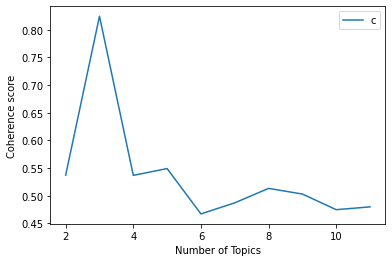

In [ ]:
x = range(2, 12)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Vemos que el número optimo de temas son tres. Se ha de tener en cuenta que el resultado puede variar de una ejecución a otra porque no siempre se construye el modelo de la misma manera. No obstante la máxima coherencia la suele ostentar el modelo de tres tema. Por esa razón vamos a construir un modelo con tres temas y intentaremos averiguar cual es cada uno.

In [ ]:
N = 3 # number of topics
lsamodel_opt = LsiModel(doc_term_matrix, num_topics = N, id2word = dictionary)

In [ ]:
N_WORDS = 15
print(lsamodel_opt.print_topics(num_topics = N, num_words=  N_WORDS))

[(0, '0.361*"trump" + 0.272*"say" + 0.233*"said" + 0.166*"would" + 0.160*"clinton" + 0.140*"peopl" + 0.136*"one" + 0.126*"campaign" + 0.123*"year" + 0.110*"time" + 0.110*"like" + 0.108*"go" + 0.107*"eu" + 0.105*"vote" + 0.099*"new"'), (1, '0.389*"citi" + 0.370*"v" + 0.356*"h" + 0.355*"2016" + 0.354*"2017" + 0.164*"unit" + 0.159*"west" + 0.157*"manchest" + 0.116*"apr" + 0.112*"dec" + -0.108*"trump" + 0.085*"leicest" + 0.084*"liverpool" + 0.084*"chelsea" + 0.083*"palac"'), (2, '-0.612*"trump" + -0.264*"clinton" + 0.261*"eu" + 0.148*"say" + 0.137*"would" + -0.135*"donald" + 0.134*"leav" + 0.134*"uk" + -0.119*"republican" + 0.110*"cameron" + 0.105*"brexit" + 0.104*"britain" + 0.100*"govern" + -0.099*"hillari" + -0.088*"state"')]


*   Tema 1: Elecciones presidenciales de EEUU de 2016 (trump, say, said, would, clinton, peopl, one, campaign, year, time, like, go, eu, vote, new...)
*   Tema 2: Premier League (citi, v, h, 2016, 2017, unit, west, manchest, apr, dec, trump, leicest, liverpool, chelsea, palac...)
*   Tema 3: Brexit (trump,clinton, eu, say, would, donald, leav, uk, republican, cameron, brexit, britain, govern, hillari, state...)

